In [1]:
# Homogeneous Equilibrium Model for mass flow rate

from CoolProp.CoolProp import PropsSI

def m_dot_HEM(p1, h1, p2, A = 1e-6, Cd = .66, substance="CO2", check_for_chocked=True): # Homogeneous Equilibrium Model m_dot = Cd * A * rho2 * sqrt(2*delta_h), s1 = s2
    if p1 == p2:
        return 0  
    s1 = PropsSI("S", "P", p1, "H", h1, substance)

    s2 = s1
    h2 = PropsSI("H", "S", s2, "P", p2, substance) # nicht exakt h2, da nicht s1 = s2 (wird mit Cd korrigiert)
    rho2 = PropsSI("DMASS", "S", s2, "P", p2, substance)

    u = Cd * (2*(h1 - h2))**.5
    m_dot = A * u * rho2
    # If not chocked
    if not check_for_chocked or m_dot >= m_dot_HEM(p1, h1, p2 + 1, A, Cd, substance, check_for_chocked=False):
        return m_dot
    
    # Flow is chocked, find p2_chocked
    p2_chocked_upper = p1
    p2_chocked_lower = p2
    for _ in range(10): # binary search
        p2_chocked_mid = (p2_chocked_upper + p2_chocked_lower) / 2
        
        if m_dot_HEM(p1, h1, p2_chocked_mid - .5, A, Cd, substance, check_for_chocked=False) < m_dot_HEM(p1, h1, p2_chocked_mid + .5, A, Cd, substance, check_for_chocked=False):
            p2_chocked_lower = p2_chocked_mid
        else:
            p2_chocked_upper = p2_chocked_mid
    p2_chocked = (p2_chocked_upper + p2_chocked_lower) / 2
    return m_dot_HEM(p1, h1, p2_chocked, A, Cd, substance, check_for_chocked=False)

def m_dot_SPI(p1, h1, p2, A = 1e-6, Cd = .66, substance="CO2"): # Single Phase Incompressible m_dot = Cd * A * sqrt(2*rho*delta_p)
    rho1 = PropsSI("DMASS", "P", p1, "H", h1, substance)
    u = Cd * (2 * (p1 - p2) / rho1)**.5
    return A * u * rho1

def m_dot_dyer(p1, h1, p2, A = 1e-6, Cd = .66, substance="CO2", check_for_chocked=True):
    Tv = PropsSI("T", "P", p1, "H", h1, substance)
    pv = PropsSI("P", "T", Tv, "Q", 0, substance)
    if pv <= p2:
        # just Single Phase Problem
        return m_dot_SPI(p1, h1, p2, A, Cd, substance)
    
    kappa = ((p1 - p2) / (pv - p2))**.5
    m_dot = (kappa / (1 + kappa)) * m_dot_SPI(p1, h1, p2, A, Cd, substance) + (1 / (1 + kappa)) * m_dot_HEM(p1, h1, p2, A, Cd, substance, check_for_chocked=False)
    
    # If not chocked
    if not check_for_chocked or m_dot >= m_dot_dyer(p1, h1, p2 + 1, A, Cd, substance, check_for_chocked=False):
        return m_dot
    
    # Probieren bei m_dot_HEM max abzuschneiden (hat ganz gut funktioniert)
    # Flow is chocked, find p2_chocked
    p2_chocked_upper = p1
    p2_chocked_lower = p2
    for _ in range(10): # binary search
        p2_chocked_mid = (p2_chocked_upper + p2_chocked_lower) / 2
        
        if m_dot_dyer(p1, h1, p2_chocked_mid - .5, A, Cd, substance, check_for_chocked=False) < m_dot_dyer(p1, h1, p2_chocked_mid + .5, A, Cd, substance, check_for_chocked=False):
            p2_chocked_lower = p2_chocked_mid
        else:
            p2_chocked_upper = p2_chocked_mid
    p2_chocked = (p2_chocked_upper + p2_chocked_lower) / 2
    return m_dot_dyer(p1, h1, p2_chocked, A, Cd, substance, check_for_chocked=False)

def m_dot_dyer_exp(p1, h1, p2, A = 1e-6, Cd = .66, substance="CO2", check_for_chocked=True):
    Tv = PropsSI("T", "P", p1, "H", h1, substance)
    pv = PropsSI("P", "T", Tv, "Q", 0, substance)
    if pv <= p2:
        # just Single Phase Problem
        return m_dot_SPI(p1, h1, p2, A, Cd, substance)
    
    kappa = ((p1 - p2) / (pv - p2))**.5
    _m_dot_SPI = m_dot_SPI(p1, h1, p2, A, Cd, substance)
    _m_dot_HEM = m_dot_HEM(p1, h1, p2, A, Cd, substance, check_for_chocked=False)
    m_dot = (kappa / (1 + kappa)) * _m_dot_SPI + (1 / (1 + kappa)) * _m_dot_HEM
    
    # If not chocked
    if not check_for_chocked or _m_dot_HEM >= m_dot_HEM(p1, h1, p2 + 1, A, Cd, substance, check_for_chocked=False):
        return m_dot
    
    # Probieren bei m_dot_HEM max abzuschneiden (hat ganz gut funktioniert)
    # Flow is chocked, find p2_chocked
    p2_chocked_upper = p1
    p2_chocked_lower = p2
    for _ in range(10): # binary search
        p2_chocked_mid = (p2_chocked_upper + p2_chocked_lower) / 2
        
        if m_dot_HEM(p1, h1, p2_chocked_mid - .5, A, Cd, substance, check_for_chocked=False) < m_dot_HEM(p1, h1, p2_chocked_mid + .5, A, Cd, substance, check_for_chocked=False):
            p2_chocked_lower = p2_chocked_mid
        else:
            p2_chocked_upper = p2_chocked_mid
    p2_chocked = (p2_chocked_upper + p2_chocked_lower) / 2
    return m_dot_dyer(p1, h1, p2_chocked, A, Cd, substance, check_for_chocked=False)

def m_dot(p1, h1, p2, A = 1e-6, Cd = .66, substance="CO2", model="dyer", check_for_chocked=True):
    if model == "hem":
        return m_dot_HEM(p1, h1, p2, A, Cd, substance, check_for_chocked)
    elif model == "spi":
        return m_dot_SPI(p1, h1, p2, A, Cd, substance)
    elif model == "dyer":
        return m_dot_dyer(p1, h1, p2, A, Cd, substance, check_for_chocked)
    elif model == "exp":
        return m_dot_dyer_exp(p1, h1, p2, A, Cd, substance, check_for_chocked)
    else:
        raise ValueError(f"Unknown model: {model}")


In [2]:
# Ventil Eigenschaften

from math import pi, sqrt, acos

A_0 = 8*8 * pi * 1e-6 / 4 # Öffnungsquerschnitt bei voller Öffnung in m²
alpha_null = 3 # Öffnungswinkel bei dem das Ventil beginnt zu öffnen in Grad

def Kv_fract_by_angle(alpha, alpha_null=0): # gibt Kv-Kennwert in % / 100 zur vollen Öffnung (alpha=90), Kv = Cd * A
    if alpha < 0:
        raise ValueError(f"Angle must be non-negative but got {alpha}")
    elif alpha > 90:
        raise ValueError(f"Angle must be at most 90 degrees but got {alpha}")
    if alpha_null >= 90:
        raise ValueError(f"Null angle must be less than 90 degrees but got {alpha_null}")
    if alpha < alpha_null:
        return 0.0

    # https://cdn.accentuate.io/7455157846238/1638234469524/nibco_cv-chart-b-and-i.pdf
    data = [
        (alpha_null, 0.0),
        (10, 0.01),
        (20, 0.05),
        (30, 0.16),
        (40, 0.3),
        (45, 0.37),
        (50, 0.45),
        (60, 0.58),
        (70, 0.71),
        (80, 0.87),
        (90, 1.0)
    ]
    """
    # Linear interpolation
    for i in range(len(data) - 1):
        if alpha <= data[i+1][0]:
            x0, y0 = data[i]
            x1, y1 = data[i+1]
            return y0 + (y1 - y0) * (alpha - x0) / (x1 - x0)
    """
    # Lagrange interpolation (ChatGPT)
    for i in range(len(data) - 2):
        if alpha <= data[i+2][0]:
            x0, y0 = data[i]
            x1, y1 = data[i+1]
            x2, y2 = data[i+2]
            # Lagrange interpolation
            L0 = ((alpha - x1) * (alpha - x2)) / ((x0 - x1) * (x0 - x2))
            L1 = ((alpha - x0) * (alpha - x2)) / ((x1 - x0) * (x1 - x2))
            L2 = ((alpha - x0) * (alpha - x1)) / ((x2 - x0) * (x2 - x1))
            res = y0 * L0 + y1 * L1 + y2 * L2
            if res < 0:
                return 0.0
            return res

def A_fract_by_angle(alpha, alpha_null=0): # gibt Querschnittsfläche in % zur vollen Öffnung Abhängigkeit des Öffnungswinkels zurück
    if alpha < 0:
        raise ValueError(f"Angle must be non-negative but got {alpha}")
    elif alpha > 90:
        raise ValueError(f"Angle must be at most 90 degrees but got {alpha}")
    if alpha_null >= 90:
        raise ValueError(f"Null angle must be less than 90 degrees but got {alpha_null}")
    if alpha < alpha_null:
        return 0.0
    d = 2  - 2 * (alpha - alpha_null) / (90 - alpha_null)
    return acos(d / 2) / (pi / 2) - d * sqrt(1 - (d / 2)**2) / pi

def Cd_by_angle(alpha, alpha_null=0):
    if alpha_null >= 90:
        raise ValueError(f"Null angle must be less than 90 degrees but got {alpha_null}")
    A_frac = A_fract_by_angle(alpha, alpha_null=alpha_null)
    Kv_frac = Kv_fract_by_angle(alpha)
    if A_frac == 0:
        return .3  # to avoid division by zero
    Cd = Kv_frac / A_frac
    if Cd > 1:
        if Cd > 1.05:
            print(f"Warning: Cd > 1 ({Cd}) at alpha = {alpha}°, alpha_null = {alpha_null}°")
        return 1.0
    return Cd

In [3]:
# Injektor Eigenschaften

from math import pi

A_inj = (20 * .5 * .5 / 4 * pi) * 1e-6 # m²
Cd_inj = 0.66

In [4]:
# System Eigenschaften

from CoolProp.CoolProp import PropsSI

substance = "N2O"
alpha = 30

T1 = 300 # K
p3 = 1.5e6 # Pa (Brennekammerdruck)

p1 = PropsSI("P", "T", T1, "Q", 0, substance) + 100 # Sättigungsdruck bei T1 + supercharged
h1 = PropsSI("H", "T", T1, "P", p1, substance)


# Mögliche Drücke p2
p2s = [p2 for p2 in range(int(p3), int(p1 - 10_000), 100_000)]
p2s += [p2 for p2 in range(p2s[-1] + 10_000, int(p1), 5_000)]

def m_dot_system_for_angle(alpha, depth=20, _A_0=A_0, model_vent="dyer", model_inj="hem"):
    # Find p2 where m1 = m2
    p2_lower = p3
    p2_upper = p1
    for _ in range(depth): # binary search
        p2_mid = (p2_lower + p2_upper) / 2
        m1 = m_dot(p1, h1, p2_mid,  A=_A_0 * A_fract_by_angle(alpha, alpha_null=alpha_null), Cd=Cd_by_angle(alpha, alpha_null=alpha_null), substance=substance, model=model_vent)
        m2 = m_dot(p2_mid, h1, p3, A=A_inj, Cd=Cd_inj, substance=substance, model=model_inj)
        if m1 < m2:
            p2_upper = p2_mid
        else:
            p2_lower = p2_mid
    p2_solution = (p2_lower + p2_upper) / 2
    m1 = m_dot(p1, h1, p2_solution,  A=_A_0 * A_fract_by_angle(alpha, alpha_null=alpha_null), Cd=Cd_by_angle(alpha, alpha_null=alpha_null), substance=substance, model=model_vent)
    m2 = m_dot(p2_solution, h1, p3, A=A_inj, Cd=Cd_inj, substance=substance, model=model_inj)
    m_dot_solution = (m1 + m2) / 2
    return m_dot_solution, p2_solution

dyer-hem: Gleichgewichtspunkt bei p2 = 5817611.189905601 Pa: 0.08023145855269907 kg/s
hem-hem: Gleichgewichtspunkt bei p2 = 5816301.509901648 Pa: 0.08020896226716953 kg/s


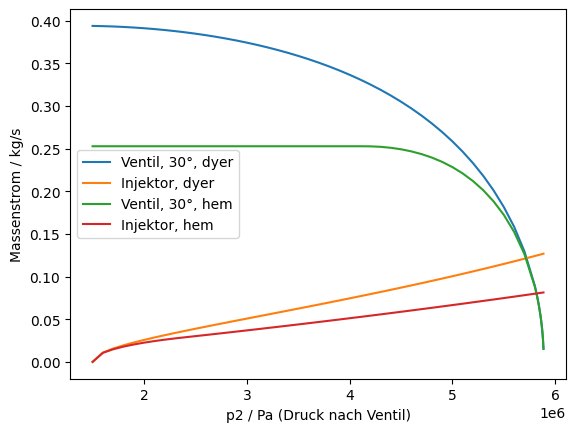

In [5]:
# Diagramm Massenströme - p2

import matplotlib.pyplot as plt

m1s = []
m2s = []

models = ["dyer", "hem"]
for model in models:
    m1s.append([])
    m2s.append([])
    for p2 in p2s:
        m1 = m_dot(p1, h1, p2,  A=A_0 * A_fract_by_angle(alpha, alpha_null=alpha_null), Cd=Cd_by_angle(alpha, alpha_null=alpha_null), substance=substance, model=model)
        m2 = m_dot(p2, h1, p3, A=A_inj, Cd=Cd_inj, substance=substance, model=model)
        m1s[-1].append(m1)
        m2s[-1].append(m2)


    m_sol, p2_sol = m_dot_system_for_angle(alpha, model_vent=model, model_inj="hem")
    print(model + "-" + "hem: Gleichgewichtspunkt bei p2 =", p2_sol, "Pa:", m_sol, "kg/s")

    plt.plot(p2s, m1s[-1], label=f"Ventil, {alpha}°, {model}")
    plt.plot(p2s, m2s[-1], label=f"Injektor, {model}")

plt.xlabel("p2 / Pa (Druck nach Ventil)")
plt.ylabel("Massenstrom / kg/s")
plt.legend()

Calculating for model: dyer-hem
Calculating for model: dyer-dyer


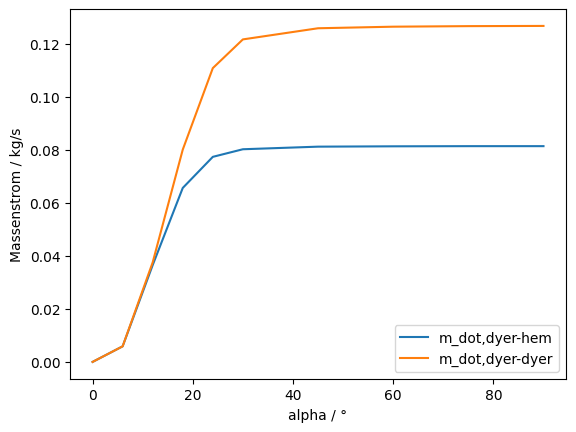

In [6]:
# Diagramm Alpha - Massenstrom

models = [["dyer", "hem"], ["dyer", "dyer"]] # "exp",

alphas = [alpha for alpha in range(0, 31, 6)] + [alpha for alpha in range(30, 91, 15)]
m_dots = []
p2_solutions = []
for model_vent, model_inj in models:
    print(f"Calculating for model: {model_vent}-{model_inj}")
    m_dots.append([])
    p2_solutions.append([])
    for _alpha in alphas:
        m_dot_solution, p2_solution = m_dot_system_for_angle(_alpha, model_vent=model_vent, model_inj=model_inj, depth=20)
        m_dots[-1].append(m_dot_solution)
        p2_solutions[-1].append(p2_solution)

    plt.plot(alphas, m_dots[-1], label=f"m_dot,{model_vent}-{model_inj}")
    #plt.plot(alphas, p2_solutions[-1], label=f"p2,{model_vent}-{model_inj}")
plt.xlabel("alpha / °")
plt.ylabel("Massenstrom / kg/s")
plt.legend()

Calculating for D = 8 mm (dyer-hem)
Calculating for D = 4 mm (dyer-hem)
Calculating for D = 3 mm (dyer-hem)


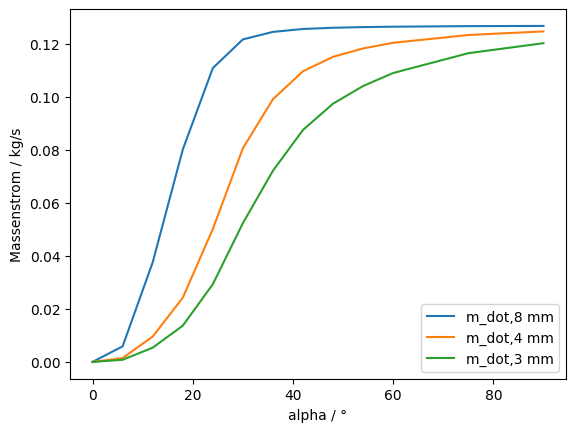

In [7]:
# Diagramm Alpha - Massenstrom Verschiedene A_0

D_0s = [8, 4, 3] # D in mm

alphas = [alpha for alpha in range(0, 61, 6)] + [alpha for alpha in range(60, 91, 15)]
m_dots = []
p2_solutions = []
for D_0 in D_0s:
    print(f"Calculating for D = {D_0} mm (dyer-hem)")
    m_dots.append([])
    p2_solutions.append([])
    for _alpha in alphas:
        m_dot_solution, p2_solution = m_dot_system_for_angle(_alpha, _A_0 = D_0 * D_0 * pi * 1e-6 / 4, model_vent="dyer", model_inj="dyer", depth=20)
        m_dots[-1].append(m_dot_solution)
        p2_solutions[-1].append(p2_solution)

    plt.plot(alphas, m_dots[-1], label=f"m_dot,{D_0} mm")
    #plt.plot(alphas, p2_solutions[-1], label=f"p2,{D_0} mm")
plt.xlabel("alpha / °")
plt.ylabel("Massenstrom / kg/s")
plt.legend()

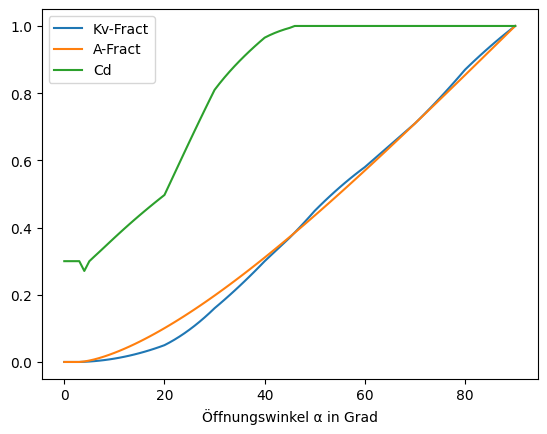

In [8]:
# Ventil Eigenschaften Visualisierung

import matplotlib.pyplot as plt

alphas = [i for i in range(91)]
kv_fracts = [Kv_fract_by_angle(alpha, alpha_null=alpha_null) for alpha in alphas]
A_fracts = [A_fract_by_angle(alpha, alpha_null=alpha_null) for alpha in alphas]
Cds = [Cd_by_angle(alpha, alpha_null=alpha_null) for alpha in alphas]

plt.plot(alphas, kv_fracts, label="Kv-Fract")
plt.plot(alphas, A_fracts, label="A-Fract")
plt.plot(alphas, Cds, label="Cd")
plt.xlabel("Öffnungswinkel α in Grad")
plt.legend()

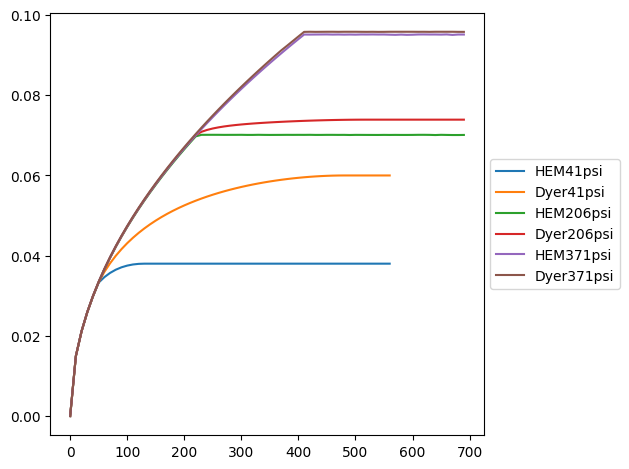

In [9]:
# recreate Fig 13

import matplotlib.pyplot as plt
from math import pi

p1s_super_psi = [41, 79, 115, 169, 206, 269, 290, 329, 371]
p1s_psig = [568, 616, 668, 705, 752, 808, 837, 896, 937]
T1s = [280, 281, 282, 281, 282, 281, 282, 283, 283]

p1s_super = [p_psi * 6894.76 for p_psi in p1s_super_psi]
p1s = [p_psi * 6894.76 + 101325 for p_psi in p1s_psig]

dps_psi = [dp_psi for dp_psi in range(0, 700, 10)]
dps = [p_psi * 6894.76 for p_psi in dps_psi]

_A = (.75*.75 * pi) * 1e-6
_Cd = .77

ms_HEM = []
ms_SPI = []
ms_dyer =[]

for i in [0, 4, 8]:
    ms_HEM += [[]]
    ms_SPI += [[]]
    ms_dyer += [[]]
    _p1 = p1s[i]
    for dp in dps:
        _T1 = T1s[i]
        p2 = _p1 - dp
        if p2 <= 100_000:
            ms_HEM[i] += [None]
            ms_SPI[i] += [None]
            ms_dyer[i] += [None]
            continue
        _h1 = PropsSI("H", "P", _p1, "T", _T1, "N2O")
        ms_HEM[-1] += [m_dot_HEM(_p1, _h1, p2, _A, _Cd, "N2O", check_for_chocked=True)]
        #ms_SPI[-1] += [m_dot_SPI(_p1, _h1, p2, _A, _Cd, "N2O")]
        ms_dyer[-1] += [m_dot_dyer(_p1, _h1, p2, _A, _Cd, "N2O", check_for_chocked=True)]
    #plt.plot(dps_psi, ms_SPI[-1], label=f"SPI{p1s_super_psi[i]}psi")
    plt.plot(dps_psi, ms_HEM[-1], label=f"HEM{p1s_super_psi[i]}psi")
    plt.plot(dps_psi, ms_dyer[-1], label=f"Dyer{p1s_super_psi[i]}psi")

# Place the legend outside the plot on the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # adjusts layout to make space for the legend